# Separation

Let's think about the essential pieces here:
- a particle has a position and can move around
- a group of particles with diagnostics for
    - center of mass
    - moment of inertia
- a random number generator
- a periodic 2d domain

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

Typical scientific software looks like this: There's a piece of code that does it all. There are hardly any abstractions. Dependencies are hard to figure out, etc.

In [2]:
class PeriodicSpace:
    def __init__(self, length_x=10, length_y=20):
        self.length_y = length_y
        self.length_x = length_x
        
    def __str__(self):
        return (
            f"PeriodicSpace("
            f"length_x={self.length_x}, "
            f"length_y={self.length_y}"
            f")"
        )

    def apply_periodicity(self, y, x):
        return np.mod(y, self.length_y), np.mod(x, self.length_x)

In [3]:
class Particle:
    def __init__(
        self,
        rng=np.random.RandomState(),
        space=PeriodicSpace(),
        x=0, y=0,
        particle_id=0,
        step_length=0.5
    ):
        self.rng = rng
        self.space = space
        self.particle_id = particle_id
        self.x, self.y = x, y
        self.step_length = step_length
        
    def __str__(self):
        return (
            f"Particle("
            f"space={self.space}, "
            f"rng={self.rng}, "
            f"particle_id={self.particle_id}, "
            f"x={self.x}, y={self.y}, "
            f"step_length={self.step_length}"
            ")"
        )

    def move(self):
        
        self.x += self.step_length * self.rng.normal()
        self.y += self.step_length * self.rng.normal()
        
        self.y, self.x = self.space.apply_periodicity(self.y, self.x)

In [4]:
class ParticleGroup:
    def __init__(
        self,
        rng=np.random.RandomState(),
        space=PeriodicSpace(),
        number_particles=100,
        step_length=0.5
    ):
        self.steps_done = 0
        self.rng = rng
        self.space = space
        self.particles = [
            Particle(
                particle_id=n, rng=rng, space=space,
                x=self.space.length_x / 2.0,
                y=self.space.length_y / 2.0,
                step_length=step_length
            )
            for n in range(number_particles)
        ]

    def __str__(self):
        return (
            f"ParticleGroup("
            f"rng={self.rng}, "
            f"space={self.space}, "
            f"number_particles={len(self.particles)}"
            ")"
        )
        
    def move(self, N=1, step=1):
        list(map(lambda p: p.move(), self.particles))
        self.steps_done += 1
        
    def positions(self):
        x = np.array([p.x for p in self.particles])
        y = np.array([p.y for p in self.particles])
        return x, y

    def center_of_mass(self):
        x, y = self.positions()
        return x.mean(), y.mean()
    
    def moment_of_inertia(self):
        x, y = self.positions()
        return x.var() + y.var()

    def diagnostics(self):
        com = self.center_of_mass()
        mi = self.moment_of_inertia()
        return pd.DataFrame(
            {
                "center_of_mass_x": com[0],
                "center_of_mass_y": com[1],
                "moment_of_inertia": mi
            },
            index=[self.steps_done, ],
        
        )

In [5]:
def run_random_walk(
    length_x=10,
    length_y=20,
    number_particles=100,
    number_steps=100,
    step_length=0.5
):
    space = PeriodicSpace(
        length_x=length_x,
        length_y=length_y
    )
    
    rng = np.random.RandomState()
    
    particles = ParticleGroup(
        space=space,
        rng=rng,
        number_particles=number_particles,
        step_length=step_length
    )
    
    diags = particles.diagnostics()
    
    for step in range(1, number_steps):
        particles.move()
        
        diags = diags.append(
            particles.diagnostics(),
            ignore_index=True
        )
        
    return diags

In [6]:
diags = run_random_walk(number_particles=100, number_steps=1000)

In [7]:
diags

,center_of_mass_x,center_of_mass_y,moment_of_inertia
0,5.000000,10.000000,0.000000
1,5.116109,10.061327,0.508012
2,5.157438,9.997413,1.024690
3,5.199722,9.999809,1.612869
4,5.274556,10.000408,1.978793
...,...,...,...
995,4.820203,10.428238,39.839033
996,4.943901,10.184864,40.808537
997,4.754630,10.405170,40.819389
998,4.665088,10.218727,42.214152


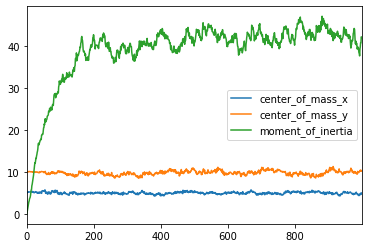

In [8]:
diags.plot();